In [1]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
import SimpleITK as sitk
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import label, regionprops

from utils import myocardial_strain_zc
from scipy.ndimage import gaussian_filter
import DeepStrain.functions_collection as ff
import DeepStrain.Data_processing as Data_processing

main_path = '/mnt/mount_zc_NAS/Deepstrain'
data_path = '/mnt/mount_zc_NAS/HFpEF/data/HFpEF_data'

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-07 00:48:29.425170: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


# load a case (its segmentation and strain)

In [2]:
patient_id = 'ID_0015'
# first: get the ED and ES frame
spreadsheet = pd.read_excel(os.path.join(data_path, 'Patient_list', 'Important_HFpEF_Patient_list_unique_patient_w_notes.xlsx' ))
patient_id_num = ff.ID_00XX_to_XX(patient_id)
patient_row = spreadsheet.loc[spreadsheet['OurID'] == patient_id_num]
ED = patient_row['ED'].values[0].astype(int)
ES = patient_row['ES'].values[0].astype(int)
print(ED,ES)

# second: load img and seg
patient_img_folder = os.path.join(data_path, 'nii_img', patient_id)
patient_seg_folder = os.path.join(data_path, 'nii_manual_seg', patient_id)

V_nifti_ED = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ED) + '.nii.gz'))
V_nifti_ES = nb.load(os.path.join(patient_img_folder, 'Org3D_frame' + str(ES) + '.nii.gz'))

M_nifti_ED = nb.load(os.path.join(patient_seg_folder, 'SAX_ED_seg.nii.gz'))
M_nifti_ES = nb.load(os.path.join(patient_seg_folder, 'SAX_ES_seg.nii.gz'))

M_nifti_ED_RV = nb.load(os.path.join(main_path,'results/trained/seg/' ,patient_id,'pred_seg_frame' + str(ED) + '.nii.gz'))
M_nifti_ES_RV = nb.load(os.path.join(main_path,'results/trained/seg/' ,patient_id,'pred_seg_frame' + str(ES) + '.nii.gz'))

# third: preprocess - change the label in segmentation: RV = 1, Myocardium = 2, LV = 3
M_ED = np.round(M_nifti_ED.get_fdata()).astype(int)
M_ED_RV = np.round(M_nifti_ED_RV.get_fdata()).astype(int)
M_ED[M_ED==1] = 3
M_ED[M_ED_RV==3] = 1
M_nifti_ED = nb.Nifti1Image(M_ED, affine=M_nifti_ED.affine, header=M_nifti_ED.header)

M_ES = np.round(M_nifti_ES.get_fdata()).astype(int)
M_ES_RV = np.round(M_nifti_ES_RV.get_fdata()).astype(int)
M_ES[M_ES==1] = 3
M_ES[M_ES_RV==3] = 1
M_nifti_ES = nb.Nifti1Image(M_ES, affine=M_nifti_ES.affine, header=M_nifti_ES.header)


# fourth: prepare input
V_nifti = nb.funcs.concat_images((V_nifti_ED, V_nifti_ES))
M_nifti = nb.funcs.concat_images((M_nifti_ED, M_nifti_ES))
print('after concat, shape: ,', V_nifti.shape)

# data was trained with:
#  in-plane resolution of 1.25 mm x 1.25 mm
#  number of slices = 16
#  variable slice thickness since we specify number of slices
V_nifti = resample_nifti(V_nifti, order=1, in_plane_resolution_mm=1.25, number_of_slices=16)
M_nifti = resample_nifti(M_nifti, order=0, in_plane_resolution_mm=1.25, number_of_slices=16)
print('after resample, shape: ', V_nifti.shape, M_nifti.shape)

# calculate center of mass using the first frame as reference. This is needed for cropping to 128x128
center = center_of_mass(M_nifti.get_fdata()[:,:,:,0]==2) # RV = 1, Myocardium = 2, LV = 3
V = _roll2center_crop(x=V_nifti.get_fdata(), center=center)
M = _roll2center_crop(x=M_nifti.get_fdata(), center=center)
print('after crop, shape: ', V.shape, M.shape, ' Labels: ', np.unique(M))

# 
V = ff.normalize_image(V)
nx, ny, nz, nt = V.shape
V_0 =  np.repeat(V[:,:,:,:1], nt-1, axis=-1)
V_t =  V[:,:,:,1:]

V_0 = np.transpose(V_0, (3,0,1,2))
V_t = np.transpose(V_t, (3,0,1,2))
print('before input into the model, the shape: ', V_0.shape, V_t.shape)

# fifth: predict motion vector
# y_t = netME([V_0, V_t]).numpy()
y_t = nb.load(os.path.join(main_path, 'models/fine_tune_carmen/ID_0015/mvf.nii.gz')).get_fdata()
y_t = y_t[None,...]
print('y_t shape: ', y_t.shape)

# smooth the motion fields. Note that these motion fields can be used to warp points individually, or could be 
# used to deform an endocardial contour. 
y_t = gaussian_filter(y_t, sigma=(0,2,2,0,0))

# last: calculate strain 
mask_end_diastole = M[..., 0]
mask_end_systole = M[..., 1]



1 8
after concat, shape: , (256, 256, 14, 2)
after resample, shape:  (240, 240, 16, 2) (240, 240, 16, 2)
after crop, shape:  (128, 128, 16, 2) (128, 128, 16, 2)  Labels:  [0. 1. 2. 3.]
before input into the model, the shape:  (1, 128, 128, 16) (1, 128, 128, 16)
y_t shape:  (1, 128, 128, 16, 3)


In [3]:
# calculate strain
strain = myocardial_strain_zc.MyocardialStrain(mask=mask_end_diastole, flow=y_t[0,:,:,:,:])
strain.calculate_strain(lv_label=2)
strain_es = myocardial_strain_zc.MyocardialStrain(mask=mask_end_systole, flow=y_t[0,:,:,:,:])
strain_es.calculate_strain(lv_label=2)

print('Radial strain: ', 100*strain.Err[strain.mask_rot==2].mean())  # mask_rot means moves the whole mask (segmentation) to the center of myocardium
print('Circumferential strain: ', 100*strain.Ecc[strain.mask_rot==2].mean())

Radial strain:  12.379095060444675
Circumferential strain:  -13.161914530526966


# Step 1: define the RV insertion point

(128, 128, 16) [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
(128, 128, 16) [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
7
phi_angle:  125.70961597270407


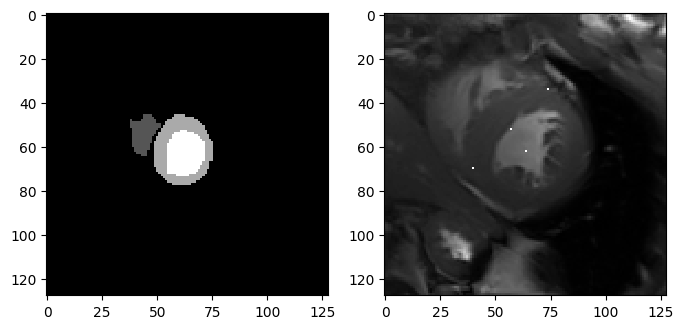

In [4]:
V_ed = V[:,:,:,0]

# define mid slice
# find the nonzero slices in the strain.mask
slice_nonzero_ed = [i for i in range(strain.mask.shape[2]) if np.sum(strain.mask[:,:,i])>0]
slice_nonzero_es = [i for i in range(strain_es.mask.shape[2]) if np.sum(strain_es.mask[:,:,i])>0]
# middle_slice
mid_slice = slice_nonzero_ed[len(slice_nonzero_ed)//2]
print(strain.mask.shape, slice_nonzero_ed)
print(strain_es.mask.shape, slice_nonzero_es)
print(mid_slice)

# find out it starts from apex or base
start_slice = np.copy(strain.mask[:,:,slice_nonzero_ed[1]]); start_slice[start_slice >0] = 1
end_slice = np.copy(strain.mask[:,:,slice_nonzero_ed[-1 - 2]]); end_slice[end_slice >0] = 1
if np.sum(start_slice) < np.sum(end_slice):
    start_slice_name = 'apex'
else:
    start_slice_name = 'base'


# define the RV insertion point
plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(strain.mask[:,:,2], cmap='gray')
# from the figure, we define the RV insertion points
ii = np.copy(V_ed[:,:,mid_slice])
insertion_p1 = [34,74]
insertion_p2 = [70,40]
ii[insertion_p1[0], insertion_p1[1]] = np.max(ii); ii[insertion_p2[0], insertion_p2[1]] = np.max(ii)

# get the rotation angle ready
phi_angle   , cx_lv, cy_lv, cx_rv, cy_rv  = myocardial_strain_zc._get_lv2rv_angle_using_insertion_points(strain.mask, insertion_p1, insertion_p2)
print('phi_angle: ', phi_angle)
ii[int(cx_lv), int(cy_lv)] = np.max(ii); ii[int(cx_rv), int(cy_rv)] = np.max(ii)
plt.subplot(122); plt.imshow(ii, cmap='gray')


# Step 2: Rotate Data

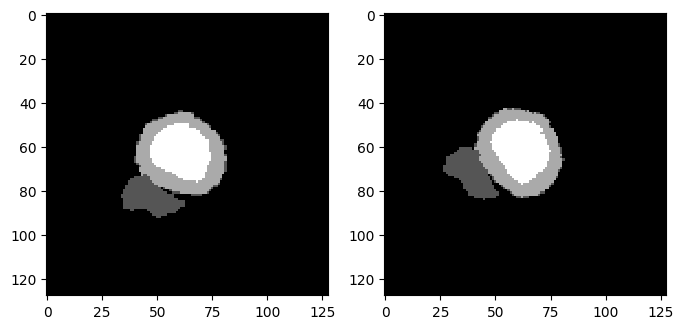

In [5]:
# rotate the data so that RV is under LV
rotate_f = myocardial_strain_zc.Rotate_data(strain.Err, strain.Ecc,strain.mask, insertion_p1, insertion_p2, non_slice_num = slice_nonzero_es )
Err_rot, Ecc_rot, mask_rot, ID = rotate_f.rotate_orientation(for_visualization=False)
Err_rot_vis, Ecc_rot_vis, mask_rot_vis, ID = rotate_f.rotate_orientation(for_visualization=True)
plt.figure(figsize=(8,4))
plt.subplot(121); plt.imshow(mask_rot[:,:,1], cmap='gray')
plt.subplot(122); plt.imshow(mask_rot_vis[:,:,1], cmap='gray')

# Step 3: Polar Sampling

In [6]:
polar = myocardial_strain_zc.PolarMap(Err_rot, Ecc_rot, mask_rot)
polar_result = polar.project_to_aha_polar_map()


... radial strain
... circumferential strain


In [8]:
Ecc_polar, Ecc_mu = polar.construct_AHA_map(polar_result['V_ecc'], start_slice_name = start_slice_name, start = 20, stop = 80)
Err_polar, Err_mu = polar.construct_AHA_map(polar_result['V_err'], start_slice_name = start_slice_name, start = 20, stop = 80)


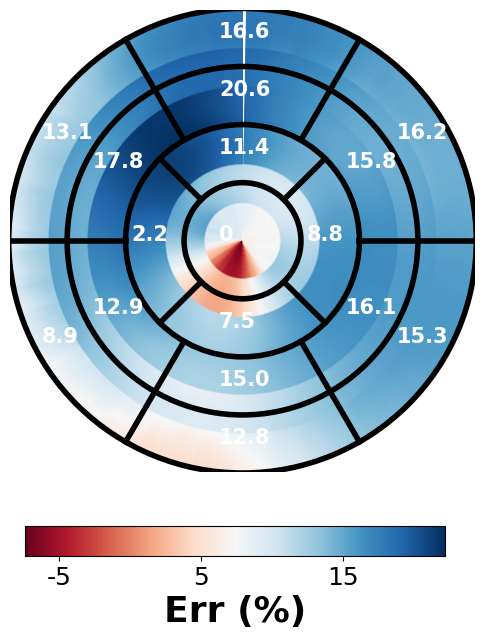

In [19]:
myocardial_strain_zc.plot_bullseye(Err_polar,Err_mu[1:],vmin=None,vmax=None, savepath=None,cmap='RdBu', label='Err (%)', 
                  std=None,cbar=True,color='white', fs=15, xshift=0, yshift=0, ptype='mesh',frac=False)

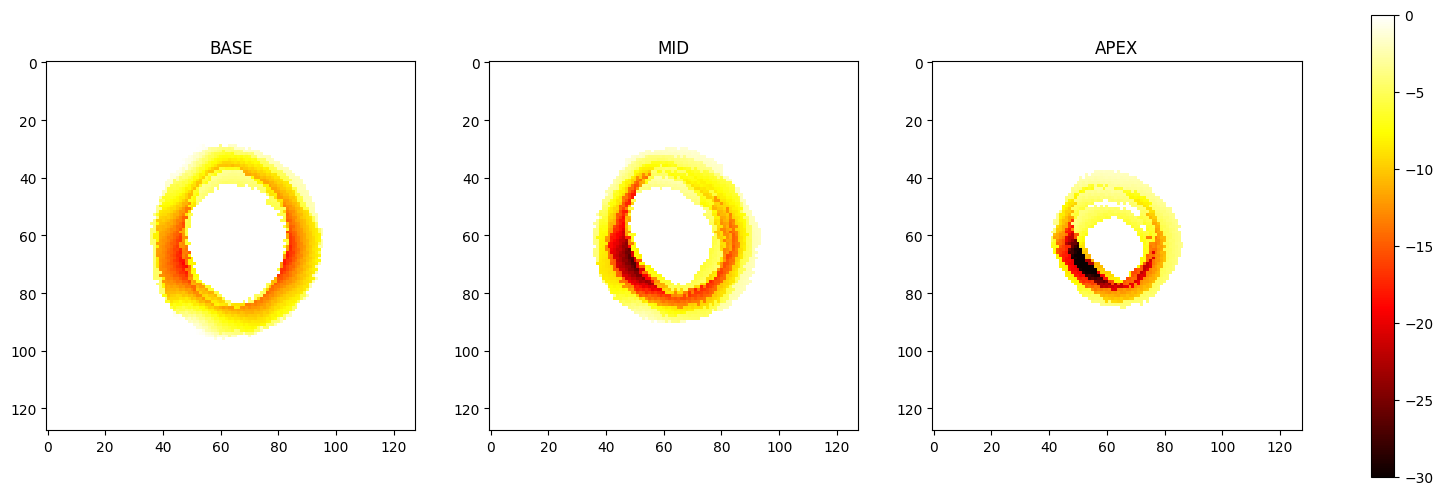

In [17]:
norm = Normalize(vmin=-30, vmax=0)

# Create a figure with two subplots
fig = plt.figure(figsize=(18, 6))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1,1])

color = 'hot'
ax1 = fig.add_subplot(gs[0])
im1 = ax1.imshow(np.mean(Ecc_rot_vis[:,:,7:10] * 100, axis = -1), cmap=color, norm=norm)
ax1.set_title('BASE')

ax2 = fig.add_subplot(gs[1])
im2 = ax2.imshow(np.mean(Ecc_rot_vis[:,:,3:7] * 100, axis = -1), cmap=color, norm=norm)
ax2.set_title('MID')

ax3 = fig.add_subplot(gs[2])
im3 = ax3.imshow(np.mean(Ecc_rot_vis[:,:,0:3] * 100, axis = -1), cmap=color, norm=norm)
ax3.set_title('APEX')

# Add colorbar
fig.colorbar(im3, ax=[ax1, ax2, ax3], orientation='vertical', fraction=0.05, pad=0.05)

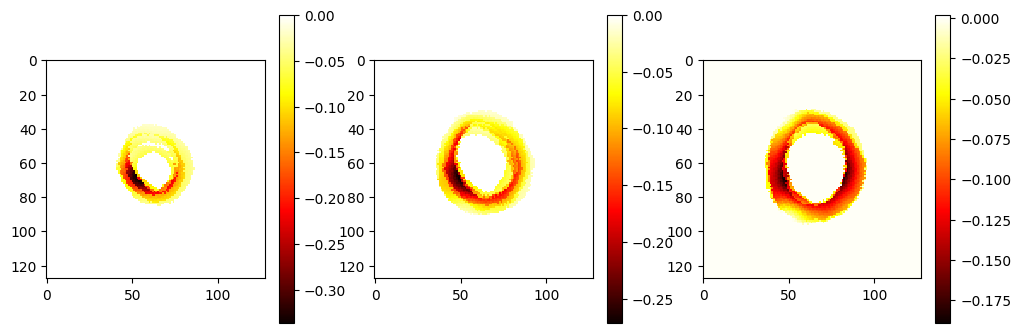

In [26]:
plt.figure(figsize=(12,4));
plt.subplot(131); plt.imshow(np.mean(Ecc_rot_vis[:,:,0:3], axis = -1), cmap='hot'); plt.colorbar()
plt.subplot(132); plt.imshow(np.mean(Ecc_rot_vis[:,:,3:7], axis = -1), cmap='hot'); plt.colorbar()
plt.subplot(133); plt.imshow(np.mean(Ecc_rot_vis[:,:,7:10], axis = -1), cmap='hot'); plt.colorbar()
